# **Import Libraries**

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


# **Load and Preprocess Dataset**

In [ ]:
# Load and preprocess the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into train, validation, and test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=73)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=73)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# **RBF**
In this block, i define the Radial Basis Function (RBF) Layer. This layer uses a set of trainable centers to compute distances between input data and these centers, applying a Gaussian function to transform the distances into feature representations.


In [ ]:
class RBFLayer(nn.Module):
    def __init__(self, input_dim, num_centers, gamma=1.0):
        super(RBFLayer, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))  # Trainable centers
        self.gamma = gamma

    def forward(self, x):
        diff = x.unsqueeze(1) - self.centers  # Calculate distance to centers
        dist = torch.sum(diff ** 2, dim=-1)
        return torch.exp(-self.gamma * dist)  # Apply Gaussian kernel


RBF Model: A model with one RBF layer followed by a Dense layer.

In [ ]:
# Define RBF Model
class RBFModel(nn.Module):
    def __init__(self, input_dim, num_centers):
        super(RBFModel, self).__init__()
        self.rbf = RBFLayer(input_dim, num_centers)
        self.fc = nn.Linear(num_centers, 1)

    def forward(self, x):
        x = self.rbf(x)
        x = self.fc(x)
        return x

# **Dense Model**

In [ ]:
# Define Dense Model
class DenseModel(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(DenseModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# **Training and Evaluation**

In [ ]:
# Training function
def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs=200):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, X_test, y_test, criterion):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = criterion(y_pred, y_test)
        r2 = r2_score(y_test.numpy(), y_pred.numpy())
    return test_loss.item(), r2


# **Train and Evaluate RBF Model**

In [ ]:
# Hyperparameters for RBF model
input_dim = X_train.shape[1]
num_centers = 64
gamma = 1
lr = 0.01
epochs = 200

# Initialize model, optimizer, and loss function
rbf_model = RBFModel(input_dim, num_centers)
optimizer = optim.Adam(rbf_model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Train the RBF model
rbf_train_losses, rbf_val_losses = train_model(
    rbf_model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs=epochs
)

# Evaluate the RBF model
rbf_test_loss, rbf_test_r2 = evaluate_model(rbf_model, X_test, y_test, criterion)
print(f"RBF Model Test Loss: {rbf_test_loss:.4f}, R² Score: {rbf_test_r2:.4f}")


# **Train and Evaluate Dense Model**

In [ ]:
# Hyperparameters for Dense model
hidden_units = 64

# Initialize model, optimizer, and loss function
dense_model = DenseModel(input_dim, hidden_units)
optimizer = optim.Adam(dense_model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Train the Dense model
dense_train_losses, dense_val_losses = train_model(
    dense_model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs=epochs
)

# Evaluate the Dense model
dense_test_loss, dense_test_r2 = evaluate_model(dense_model, X_test, y_test, criterion)
print(f"Dense Model Test Loss: {dense_test_loss:.4f}, R² Score: {dense_test_r2:.4f}")


Dense Model Test Loss: 0.3025, R² Score: 0.7736


# **Plot Losses**

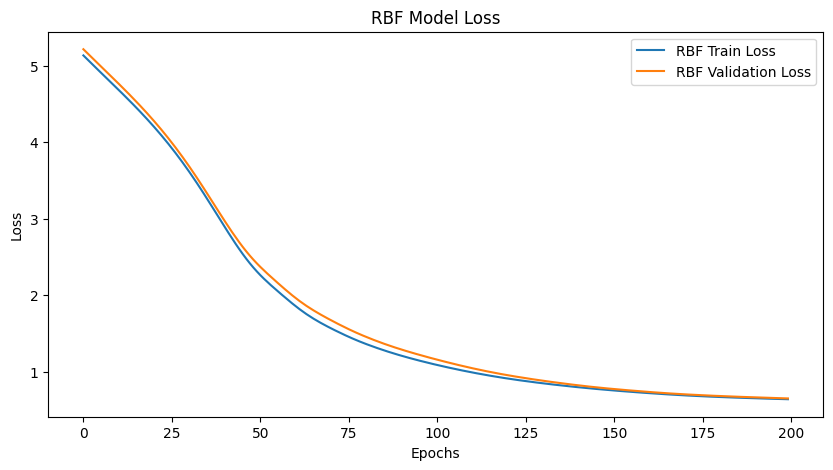

In [ ]:
# Plot train and validation loss for RBF model
plt.figure(figsize=(10, 5))
plt.plot(rbf_train_losses, label="RBF Train Loss")
plt.plot(rbf_val_losses, label="RBF Validation Loss")
plt.title("RBF Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



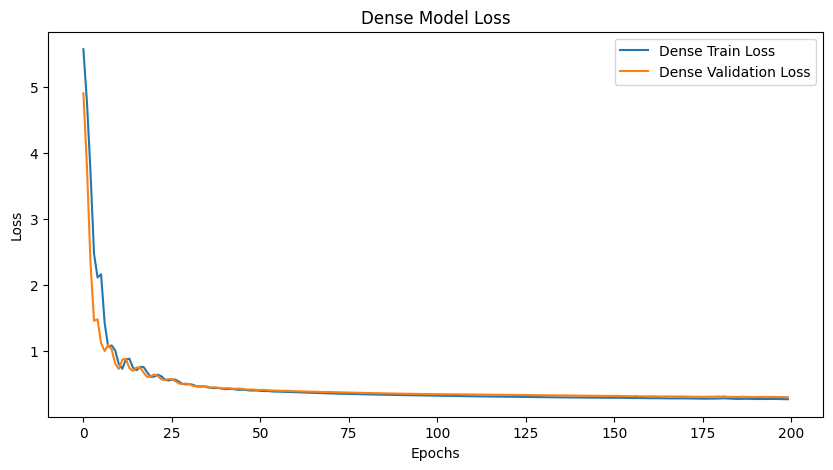

In [ ]:
# Plot train and validation loss for Dense model
plt.figure(figsize=(10, 5))
plt.plot(dense_train_losses, label="Dense Train Loss")
plt.plot(dense_val_losses, label="Dense Validation Loss")
plt.title("Dense Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# **Compaer Models**

In [ ]:
# Calculate average train and validation loss for both models
rbf_avg_train_loss = np.mean(rbf_train_losses)
rbf_avg_val_loss = np.mean(rbf_val_losses)
dense_avg_train_loss = np.mean(dense_train_losses)
dense_avg_val_loss = np.mean(dense_val_losses)

# Calculate R² scores for train and validation sets for RBF model
rbf_model.eval()
with torch.no_grad():
    rbf_train_r2 = r2_score(y_train.numpy(), rbf_model(X_train).numpy())
    rbf_val_r2 = r2_score(y_val.numpy(), rbf_model(X_val).numpy())

# Calculate R² scores for train and validation sets for Dense model
dense_model.eval()
with torch.no_grad():
    dense_train_r2 = r2_score(y_train.numpy(), dense_model(X_train).numpy())
    dense_val_r2 = r2_score(y_val.numpy(), dense_model(X_val).numpy())

# Create a DataFrame to store the results
results = {
    "Model": ["RBF", "Dense"],
    "Test MSE": [rbf_test_loss, dense_test_loss],
    "Test R²": [rbf_test_r2, dense_test_r2],
    "Avg Train Loss": [rbf_avg_train_loss, dense_avg_train_loss],
    "Avg Validation Loss": [rbf_avg_val_loss, dense_avg_val_loss],
    "Train R²": [rbf_train_r2, dense_train_r2],
    "Validation R²": [rbf_val_r2, dense_val_r2],
}

results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv("model_comparison_results.csv", index=False)

# Display the results
print(results_df)


   Model  Test MSE   Test R²  Avg Train Loss  Avg Validation Loss  Train R²  \
0    RBF  0.677243  0.493150        1.741487             1.798725  0.514962   
1  Dense  0.302528  0.773588        0.472517             0.458752  0.794906   

   Validation R²  
0       0.527712  
1       0.781481  
